In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn plotly seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.9 MB ? eta -:--:--Requirement already satisfied: six>=1.5 in ./projects/lib/python3.12/site-packages (from python-dateutil>=2.8.2->pandas) (1.17.0)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 15.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 15.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [seaborn]m2/3 [seaborn]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [seaborn]


In [2]:
import torch; 
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Warning: No GPU detected and hence training may be slow.")

GPU Available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Memory: 3.95 GB


## PCA coding problem: 3D dataset with 10 points
In this section we solve parts (a)-(j): build matrix X (10×3), compute per-feature mean/std, standardize to X_std, compute covariance, eigenvalues/eigenvectors (principal directions), form projection matrix W from first two PCs, obtain 2D representation Z = X_std W, and plot a 2D scatter.

In [4]:
# (a) Create the feature matrix X ∈ R^{10×3}
import numpy as np
import pandas as pd

X = np.array([
    [2.5, 2.4, 1.0],
    [0.5, 0.7, 0.3],
    [2.2, 2.9, 0.9],
    [1.9, 2.2, 0.8],
    [3.1, 3.0, 1.1],
    [2.3, 2.7, 1.0],
    [2.0, 1.6, 0.5],
    [1.0, 1.1, 0.2],
    [1.5, 1.6, 0.4],
    [1.1, 0.9, 0.3],
], dtype=float)

print("X shape:", X.shape)
pd.DataFrame(X, columns=["x1","x2","x3"])

X shape: (10, 3)


,x1,x2,x3
0,2.5,2.4,1.0
1,0.5,0.7,0.3
2,2.2,2.9,0.9
3,1.9,2.2,0.8
4,3.1,3.0,1.1
5,2.3,2.7,1.0
6,2.0,1.6,0.5
7,1.0,1.1,0.2
8,1.5,1.6,0.4
9,1.1,0.9,0.3


In [7]:
# (b) Mean and standard deviation of each feature over 10 points
# By convention for standardization we use population std (ddof=0), same as scikit-learn StandardScaler
mu = X.mean(axis=0)
sigma = X.std(axis=0, ddof=0)

pd.DataFrame({"mean": mu, "std": sigma}, index=["x1","x2","x3"])

,mean,std
x1,1.81,0.744916
x2,1.91,0.803057
x3,0.65,0.326343


In [8]:
# (c) Standardize to zero mean and unit variance: X_std
X_std = (X - mu) / sigma

# Check zero mean and unit variance (numerical tolerance)
print("Means of X_std:", X_std.mean(axis=0))
print("Stds  of X_std:", X_std.std(axis=0, ddof=0))

pd.DataFrame(X_std, columns=["x1_std","x2_std","x3_std"])

Means of X_std: [-7.77156117e-17  4.21884749e-16  0.00000000e+00]
Stds  of X_std: [1. 1. 1.]


,x1_std,x2_std,x3_std
0,0.926279,0.610169,1.072490
1,-1.758587,-1.506743,-1.072490
2,0.523549,1.232790,0.766064
3,0.120819,0.361120,0.459639
4,1.731739,1.357314,1.378916
5,0.657792,0.983741,1.072490
6,0.255062,-0.386025,-0.459639
7,-1.087371,-1.008646,-1.378916
8,-0.416154,-0.386025,-0.766064
9,-0.953127,-1.257695,-1.072490


In [9]:
# (d) 3×3 covariance matrix of X_std
# Using unbiased estimator (n-1) to match standard covariance definition
Cov = np.cov(X_std, rowvar=False, bias=False)
print("Covariance matrix (X_std):\n", np.round(Cov, 6))

Covariance matrix (X_std):
 [[1.111111 1.02881  1.016963]
 [1.02881  1.111111 1.057808]
 [1.016963 1.057808 1.111111]]


In [10]:
# (e) Eigenvalues and eigenvectors of covariance matrix
# Cov is symmetric; use eigh which returns eigenvalues in ascending order
vals, vecs = np.linalg.eigh(Cov)
# (f) Sort in descending order
idx = np.argsort(vals)[::-1]
vals_sorted = vals[idx]
vecs_sorted = vecs[:, idx]

# Normalize eigenvectors (should already be unit length)
vecs_sorted = vecs_sorted / np.linalg.norm(vecs_sorted, axis=0, keepdims=True)

print("Eigenvalues (desc):", np.round(vals_sorted, 6))
print("Eigenvectors (columns, matching eigenvalues):\n", np.round(vecs_sorted, 6))

Eigenvalues (desc): [3.180261 0.10077  0.052302]
Eigenvectors (columns, matching eigenvalues):
 [[-0.572981 -0.811005  0.118172]
 [-0.580607  0.299909 -0.756934]
 [-0.578436  0.502321  0.642717]]


In [11]:
# (g) Report eigenpairs (principal directions) neatly
report = pd.DataFrame(vecs_sorted, columns=[f"PC{i+1}" for i in range(3)], index=["x1","x2","x3"]).copy()
report.loc["eigenvalue"] = vals_sorted
report

,PC1,PC2,PC3
x1,-0.572981,-0.811005,0.118172
x2,-0.580607,0.299909,-0.756934
x3,-0.578436,0.502321,0.642717
eigenvalue,3.180261,0.100770,0.052302


In [12]:
# (h) Projection matrix W from first two principal components (PC1, PC2)
W = vecs_sorted[:, :2]  # shape 3×2
print("W shape:", W.shape)
print(W)

W shape: (3, 2)
[[-0.5729807  -0.81100456]
 [-0.58060709  0.29990938]
 [-0.57843628  0.50232058]]


In [13]:
# (i) Compute the 2D representation Z = X_std W ∈ R^{10×2}
Z = X_std @ W
print("Z shape:", Z.shape)
pd.DataFrame(Z, columns=["z1","z2"])

Z shape: (10, 2)


,z1,z2
0,-1.505375,-0.029487
1,2.502829,0.435602
2,-1.458869,0.329935
3,-0.544768,0.241205
4,-2.577934,-0.304719
5,-1.568437,0.300295
6,0.343855,-0.553515
7,2.006284,-0.113298
8,0.905697,-0.163079
9,1.896717,-0.142937


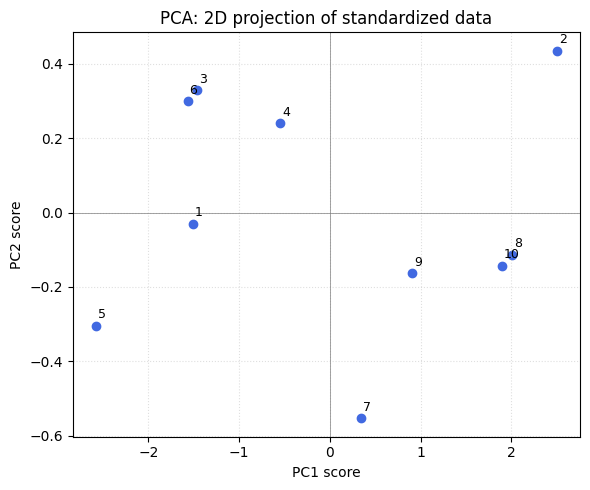

In [14]:
# (j) 2D scatter plot of rows of Z
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], color="royalblue")
for i, (x, y) in enumerate(Z):
    plt.text(x+0.02, y+0.02, str(i+1), fontsize=9)
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.title("PCA: 2D projection of standardized data")
plt.xlabel("PC1 score")
plt.ylabel("PC2 score")
plt.grid(True, linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()